In [1]:
#################### Multiclass Logistic Regression (Softmax) ####################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#################### Hyperparameters
epoch = 100
etta = 0.01
threshold = 0.5
train_rate = 0.7
val_rate = 0.1
test_rate = 0.2



#################### Loading Dataset and Preprocessing
df = pd.read_csv("iris/iris.data")
data = np.array(df)
M,N = np.shape(data)

X_data = data[:, :-1].astype(float)
Y_data = data[:, -1]
cls = set(Y_data)
c = 0

for item in cls:
    idx = np.where(Y_data == item)
    Y_data[idx] = c
    c += 1

Y_data = Y_data.astype(float)


def normalisation(data):
    M = np.max(data, axis=0)
    m = np.min(data, axis=0)
    out = (data - m) / (M-m)
    return out


def standardisation(data):
    out = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
    return out


X_data = standardisation(X_data)
X_data = np.hstack((np.ones((M,1)), X_data))
Y_data = np.reshape(Y_data, (M,1)).astype(float)
data = np.hstack((X_data, Y_data))


In [2]:
#################### Train-Test-Validation Split
M_train = int(np.ceil(train_rate * M)) 
M_val = int(np.ceil(val_rate * M))
M_test = M - (M_train + M_val)

idx = np.random.permutation(M)
train_idx = idx[:M_train] 
val_idx = idx[M_train: M_train+M_val]
test_idx = idx[M_train+M_val:]

X_train = data[train_idx, :-1]
Y_train = data[train_idx, -1]
X_val = data[val_idx, :-1]
Y_val = data[val_idx, -1]
X_test = data[test_idx, :-1]
Y_test = data[test_idx, -1]


In [3]:
#################### Logistic Regression Model (Softmax)

def cost_func(Y, Y_hat, n):
    new = np.apply_along_axis(np.exp, 1, Y_hat)
    D = np.sum(new, axis=1)
    new2 = np.apply_along_axis(np.exp, 1, Y_hat)
    S = new2/D[:, np.newaxis]
    Z = np.log(S) @ np.transpose(Y)
    out = (-1/n) * Z.trace()
    return out


def grad(X, Y, Y_hat, n):
    out = (1/n) * (np.transpose(X) @ (Y_hat - Y))
    return out



def my_func(arr):
    idx = int(arr[0])
    arr[idx+1] = 1
    return arr

C = len(cls)
Y_train_m = np.zeros((M_train, C))
Y_val_m = np.zeros((M_val, C))
Y_test_m = np.zeros((M_test, C))

new_1 = np.hstack((np.reshape(Y_train,(M_train,1)), Y_train_m))
new_2 = np.hstack((np.reshape(Y_val,(M_val,1)), Y_val_m))
new_3 = np.hstack((np.reshape(Y_test,(M_test,1)), Y_test_m))

Y_train_m = np.apply_along_axis(my_func, 1, new_1)
Y_train_m = Y_train_m[:, 1:]
Y_val_m = np.apply_along_axis(my_func, 1, new_2)
Y_val_m = Y_val_m[:, 1:]
Y_test_m = np.apply_along_axis(my_func, 1, new_3)
Y_test_m = Y_test_m[:, 1:]


L_train = np.array([])
L_val = np.array([])


W = np.random.rand(N,C)

for i in range(epoch):
    Y_hat_train = X_train @ W
    Y_hat_val = X_val @ W
    c_train = cost_func(Y_train_m, Y_hat_train, M_train)
    c_val = cost_func(Y_val_m, Y_hat_val, M_val)
    
    L_train = np.append(L_train, c_train)
    L_val = np.append(L_val, c_val)
    
    W = W - (etta * grad(X_train, Y_train_m, Y_hat_train, M_train))
    
    
  

In [4]:
#################### Validation and Test
def softmax(Y, Y_hat, n):
    new = np.apply_along_axis(np.exp, 1, Y_hat)
    D = np.sum(new, axis=1)
    new2 = np.apply_along_axis(np.exp, 1, Y_hat)
    S = new2/D[:, np.newaxis]
    return S



def accuracy(Y, Y_hat, n):
    out = (np.sum(Y == np.round(Y_hat))) / n
    return out

def TP(Y, Y_hat, n):
    l1 = np.where(Y == 1)
    l2 = np.where(Y_hat == 1)
    out = len(np.intersect1d(l1,l2)) / n
    return out

def FP(Y, Y_hat, n):
    l1 = np.where(Y == 0)
    l2 = np.where(Y_hat == 1)
    out = len(np.intersect1d(l1,l2)) / n
    return out

def FN(Y, Y_hat, n):
    l1 = np.where(Y == 1)
    l2 = np.where(Y_hat == 0)
    out = len(np.intersect1d(l1,l2)) / n
    return out

def TN(Y, Y_hat, n):
    l1 = np.where(Y == 0)
    l2 = np.where(Y_hat == 0)
    out = len(np.intersect1d(l1,l2)) / n
    return out


def f(X):
    out = np.ceil(np.max(X))
    return out


Y_hat_test = X_test @ W
predicts = softmax(Y_test_m, Y_hat_test, M_test)
predicts = np.argmax(predicts, 1)



In [5]:
#################### Confusion Matrix
from tabulate import tabulate

h = set(Y_data.flatten())
res = [(a, b) for a in h for b in h]

def f2(Y, Y_hat, n, i, j):
    l1 = np.where(Y == i)
    l2 = np.where(Y_hat == j)
    out = len(np.intersect1d(l1,l2))
    return out 
    
a = np.empty((C, C))

for i,j in res:
    o = f2(Y_test, predicts, M_test, i, j)
    a[int(i)][int(j)] = o

# assign data
mydata = list(a)

 
# display table
print(tabulate(mydata, tablefmt="grid"))

+---+----+---+
| 6 |  1 | 4 |
+---+----+---+
| 0 | 10 | 0 |
+---+----+---+
| 0 |  0 | 8 |
+---+----+---+


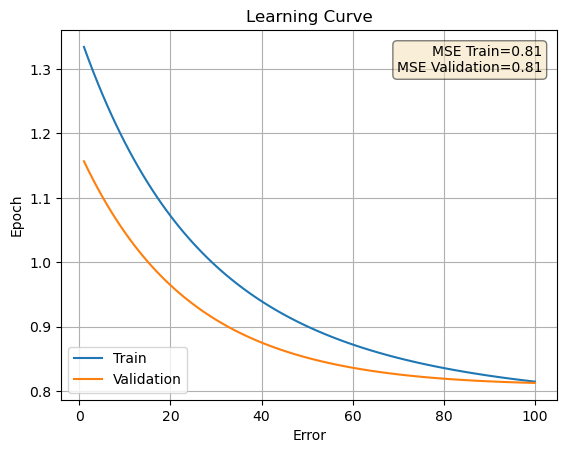

In [6]:
#################### Learning Curve

fig, ax = plt.subplots()

plt.plot(range(1, epoch+1), L_train, label='Train')
plt.plot(range(1, epoch+1), L_val, label='Validation')
plt.title("Learning Curve")
plt.xlabel("Error")
plt.ylabel("Epoch")
plt.grid()
plt.legend(loc="lower left")


txt = '\n'.join((
    r'MSE Train=%.2f' % (L_train[-1], ),
    r'MSE Validation=%.2f' % (L_val[-1], )
    ))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.text(0.97, 0.96, txt, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=props)

plt.show()